# Import packages

In [3]:
# basic 
import pandas as pd
import numpy as np
import statistics

# webs scraping and regex
from bs4 import BeautifulSoup
import requests
import lxml
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn - pre-processing
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

#sklearn - models
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

#sklearn - analysis
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# Load data set & filter out NaN

In [19]:
df = sns.load_dataset("penguins")
df = df[(df['bill_length_mm'].notna())&(df['sex'].notnull())].reset_index(drop=True)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
329,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
330,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
331,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


# Scale feature data

In [20]:
# preprocess data
# splitting the independent and dependent variables
feature_data = df[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]
label_data = df['species']

# normalization
# std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
scaled_data = mm_scaler.fit_transform(feature_data) 

# create dataframe with X and y values for fitting/testing model
df1 = pd.DataFrame(scaled_data,columns=feature_data.columns)
df1['species']=df['species']
df1

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,0.254545,0.666667,0.152542,0.291667,Adelie
1,0.269091,0.511905,0.237288,0.305556,Adelie
2,0.298182,0.583333,0.389831,0.152778,Adelie
3,0.167273,0.738095,0.355932,0.208333,Adelie
4,0.261818,0.892857,0.305085,0.263889,Adelie
...,...,...,...,...,...
328,0.549091,0.071429,0.711864,0.618056,Gentoo
329,0.534545,0.142857,0.728814,0.597222,Gentoo
330,0.665455,0.309524,0.847458,0.847222,Gentoo
331,0.476364,0.202381,0.677966,0.694444,Gentoo


# Determine whether features are independent and distinct

In [21]:
# #MATPLOTLIB PLOT
# # Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = list(group.index)
# perc = group['cnt']
# explode = (0, 0, 0.1)  # only "explode" the 3nd slice (i.e. 'chinstrap')

# fig1, ax1 = plt.subplots()
# ax1.pie(perc, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

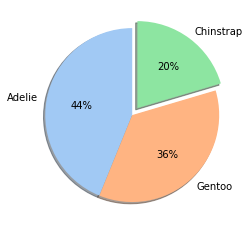

In [22]:
# create pivot table to count by species
group = df.groupby(by=['species'],sort=True).agg({'island':'count'})
group.sort_values(by=['island'],ascending=False,inplace=True)
group.columns = ['cnt']
group['perc']=group.div(group.sum(), axis=1).round(2)

# SEABORN PLOT
# visualize pivot table above
#define data
data = group['cnt']
labels = list(group.index)

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:3]
explode = (0, 0, 0.1)  # only "explode" the 3nd slice (i.e. 'chinstrap')

#create pie chart
plt.pie(data, labels = labels, colors = colors, explode=explode, shadow=True, startangle=90, autopct='%.0f%%')
plt.show()

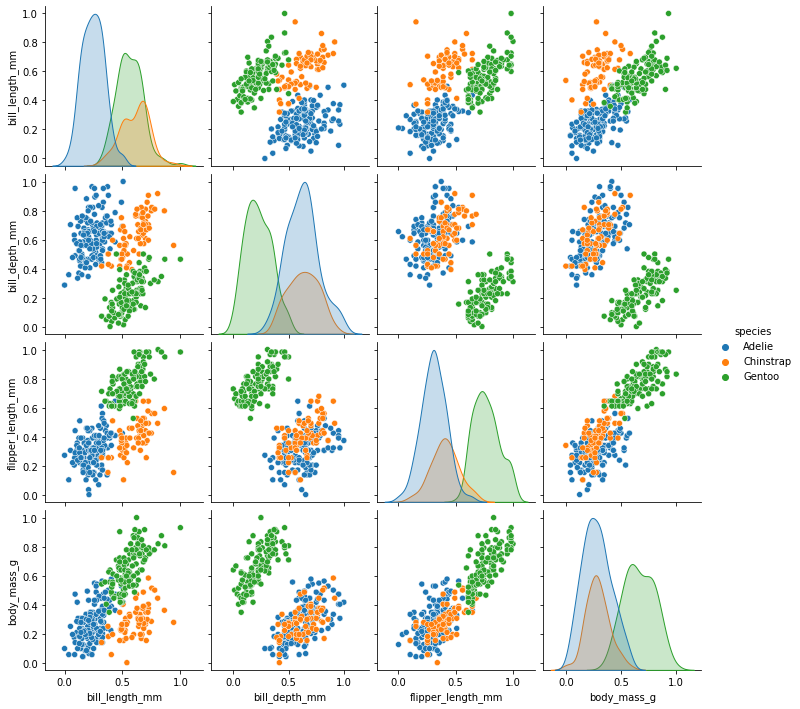

In [23]:
# evaluate independence/distinctness of data
sns.pairplot(df1, hue="species")

<AxesSubplot:>

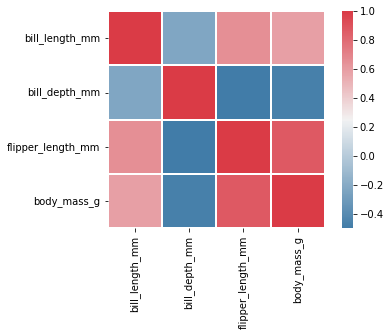

In [24]:
corr = df1.iloc[:].corr(method='pearson')
cmap = sns.diverging_palette(240, 10, n=9,center='light',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin=-.5, cmap=cmap, square=True, linewidths=.2)

# Test models & compare performance

In [25]:
# create function to generate performance results
def accuracy_test(model_name, X, y):
    # split the training dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # calculate accuracy score
    model_name.fit(X_train,y_train)
    y_pred = model_name.predict(X_test)
    labels = y.unique()
    labels = list(filter(None,labels)) 
    report = classification_report(y_test,y_pred,target_names=labels,output_dict=True)
    df_report = pd.DataFrame(report).T.round(2)
    # multilevel index names
    level2 = ['precision', 'recall','f1-score','support']
    names = ['Model', 'Category']
    # create performance table
    mltidx_name = re.findall(r'(^\w+)[(].*',str(model_name))
    columns = pd.MultiIndex.from_product([mltidx_name, level2],names=names)
    df_report.columns= columns
    return df_report

In [26]:
# assignment of variables to input and output data
X = df1.iloc[:,:4]
y = df1.iloc[:,-1]

# model names
mnb = MultinomialNB(alpha=1)
rfc = RandomForestClassifier(max_depth=4,random_state=1)

# # accuracy_test results
a = accuracy_test(mnb,X,y)
b = accuracy_test(rfc,X,y)
result = a.join(b)
result

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model        MultinomialNB                         RandomForestClassifier  \
Category         precision recall f1-score support              precision   
Adelie                0.67   1.00     0.81   29.00                   1.00   
Chinstrap             0.00   0.00     0.00   14.00                   0.88   
Gentoo                1.00   1.00     1.00   24.00                   1.00   
accuracy              0.79   0.79     0.79    0.79                   0.97   
macro avg             0.56   0.67     0.60   67.00                   0.96   
weighted avg          0.65   0.79     0.71   67.00                   0.97   

Model                                 
Category     recall f1-score support  
Adelie         0.97     0.98   29.00  
Chinstrap      1.00     0.93   14.00  
Gentoo         0.96     0.98   24.00  
accuracy       0.97     0.97    0.97  
macro avg      0.97     0.96   67.00  
weighted avg   0.97     0.97   67.00

# Performance scores based on proportion of training data

In [27]:
# Check on how the training data sets perform with varying split percentages and 1000 shuffles
def proportion_of_training(model_name,X1,y1):
    t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    plt.figure()
    for s in t:
        scores = []
        for i in range(1,1000):
            X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 1-s,random_state=42)
            model_name.fit(X_train, y_train)
            scores.append(model_name.score(X_test, y_test))
        plt.plot(s, np.mean(scores), 'bo')
    plt.xlabel('Training set proportion (%)')
    plt.ylabel('accuracy')
    title = re.findall(r'(^\w+)[(].*',str(model_name))
    plt.title(title);

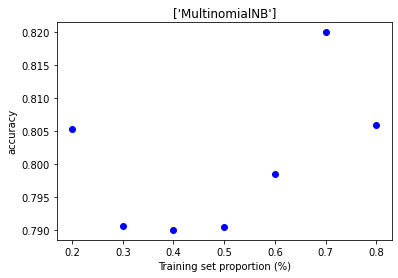

In [ ]:
proportion_of_training(mnb,X,y)

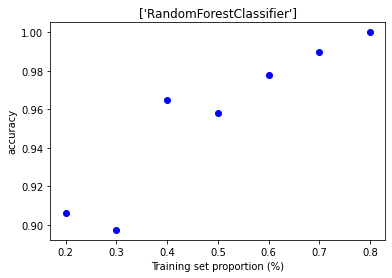

In [ ]:
proportion_of_training(rfc,X,y)

In [28]:
# test sample that should be classified at 'Adelie'
sample = [0.269094 ,0.511905, 0.237288, 0.305556]
def make_prediction(sample_data):
    pred = mnb.predict([sample_data])
    outcome = [max(x) for x in mnb.predict_proba([sample_data])]
    return outcome, pred

make_prediction(sample)

# print('prediction:',mnb.predict([sample]),'\n probability:',[max(x) for x in mnb.predict_proba([sample])])
# print('prediction:',rfc.predict([sample]),'\n probability:',[max(x) for x in rfc.predict_proba([sample])])

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


([0.4975182023512631], array(['Adelie'], dtype='<U9'))

In [39]:
# fake data to process using model above

#create fake values that correspond with each feature
bill_length = np.random.randint(39,50,100)
bill_depth = np.random.randint(13,19,100)
flipper_length = np.random.randint(181,213,100)
body_mass_g = np.random.randint(3750,5400,100)

# create list of features and assign column names, then convert to dataframe
lst = [bill_length, bill_depth, flipper_length, body_mass_g]
cols = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
dct_sample = dict(zip(cols,lst))
sample = pd.DataFrame(dct_sample,index = range(100))
sample.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,49,17,187,4873
1,40,18,199,5231
2,47,18,211,4644
3,39,16,181,3780
4,42,15,200,4296


In [60]:
#pipeline
def make_prediction(X,y,sample_data):
    pipe = make_pipeline(mm_scaler,rfc)
    pipe.fit(X,y)
    # X_new = sample_data
    outcome_label = pipe.predict(sample_data)
    outcome_label = list(outcome_label)
    outcome_per = [max(x) for x in pipe.predict_proba(sample_data)]
    dct = dict(zip(outcome_label,outcome_per))
    df = pd.DataFrame(outcome_label, index=range(len(sample.index)), columns=['species'])
    df['prob'] = outcome_per
    # cross_val_score(pipe, X, y,...)
    return sample.join(df)

df_outcome = make_prediction(feature_data,label_data,sample)
df_outcome.sort_values('prob',ascending=False,inplace=True)
df_c = df_outcome.iloc[:30,:]


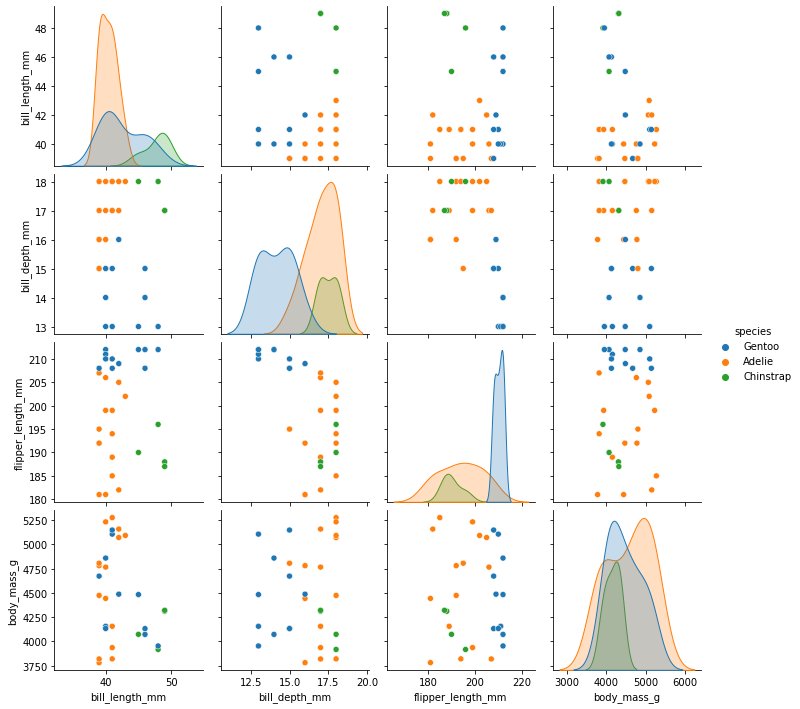

In [61]:
# X_sample = X.sample(5,random_state=99)
# X_new
chart = df_c[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]
species_label = df_outcome['species']
full_chart = chart.join(species_label)
sns.pairplot(full_chart, hue="species")
# chart

In [166]:
from ml_testing import proportion_of_training
print(proportion_of_training.__doc__)


    Check on how the training data sets perform with varying split percentages and 1000 shuffles.
    Model_name = This is the model + hyperparameters, e.g., mnb = multinomialNB(alpha=1)
    X1 = The features for the model, e.g., df.iloc[:,4]
    y = The label that the features are to predict, e.g., df.iloc[:,-1]
    


In [ ]:
help(proportion_of_training)

Help on function proportion_of_training in module ml_testing:

proportion_of_training(model_name, X, y)
    Check on how the training data sets perform with varying split percentages and 1000 shuffles.
    Model_name = This is the model + hyperparameters, e.g., mnb = multinomialNB(alpha=1)
    X1 = The features for the model, e.g., df.iloc[:,4]
    y = The label that the features are to predict, e.g., df.iloc[:,-1]



In [167]:
from ml_testing import accuracy_test
help(accuracy_test)

Help on function accuracy_test in module ml_testing:

accuracy_test(model_name, X, y)
    Check on how the training data sets perform with varying split percentages and 1000 shuffles.
    Model_name = This is the model + hyperparameters, e.g., mnb = multinomialNB(alpha=1)
    X1 = The features for the model, e.g., df.iloc[:,4]
    y1 = The label that the features are to predict, e.g., df.iloc[:,-1]

